#  <span style='color:blue'> Handwritten Digit Classification Using the MNIST Dataset – A Comprehensive Comparison of Machine Learning Models and Grid Search Optimization </span>
**Author :** [Bitewulign Kassa Mekonnen](https://scholar.google.com/citations?user=SHPCjakAAAAJ&hl=en)<br>
**Instructor :** Hossein Pourmodheji <br>
**Lab Assistant :** Sebastian<br>
**Date created :**  2024/10/10<br>
**Last modified :** 2024/10/21  <br>

**Objective:** To apply various preprocessing and machine learning techniques to 
classify handwritten digits from the MNIST (alternative link) dataset without using 
deep learning methods. <br>

**Project Description :** The MNIST dataset is a collection of 70,000 grayscale images of handwritten digits (0-9), 60,000 train and 10,000 test datasets. Each image is 28x28 pixels. The goal of this project is to build a machine learning model that can accurately classify these images into the correct digit categories. <br>


<span style='color:red; font-size: 12px;'> <b>Note:</b>  This project is developed to fulfill the requirements of the Bridge to Cloud Computing and Big Data course. </span>

### Import necessary libraries

In [2]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import (RandomForestClassifier as RFC, 
                              GradientBoostingClassifier as GBC)
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import (classification_report,
                             precision_score,
                            recall_score, 
                            f1_score,
                            confusion_matrix, 
                            accuracy_score,
                            precision_recall_curve,
                            roc_auc_score,
                            roc_curve,
                            auc,
                            ConfusionMatrixDisplay,
                            precision_recall_curve, 
                             average_precision_score)
#from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import label_binarize
%matplotlib inline

<center>
<b><span style="font-size: 36px;">Part 1: Data Preprocessing</span></b>
</center>


1. Data Loading:

    ➢ Use fetch_openml from scikit-learn to load the MNIST dataset.
    
    ➢ Explore the dataset to understand its structure (number of samples, feature dimentions, etc.)
    
2. Data Normalization:

    ➢ Normalize the pixel values to a range of 0 to 1 to ensure uniformity in the input data scale. 
    
3. Data Visualization: 

    ➢ Visualize a subset of images using matplotlib to get a sense of what the handwritten digits look like. 
    
4. Dimentionality Reduction (optional):

    ➢ Apply PCA to reduce the dimentionality of the dataset while preserving most of the variance.

In [3]:
# 1. Data Loading
mnist = fetch_openml('mnist_784', as_frame=False)
X_data, Y_data = mnist.data, mnist.target
# Convert target to integer
Y_data = Y_data.astype(np.int64)
# 2. Data Normalization (normalize pixel values to range [0,1])
X_data = X_data / 255.0

In [4]:

# 3. Data Visualization
def plot_sample_images(X, y, n_samples=10):
    plt.figure(figsize=(10, 10))
    # Calculate the grid size
    rows_cols = int(np.ceil(np.sqrt(n_samples)))
    for i in range(n_samples):
        plt.subplot(rows_cols, rows_cols, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        #plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

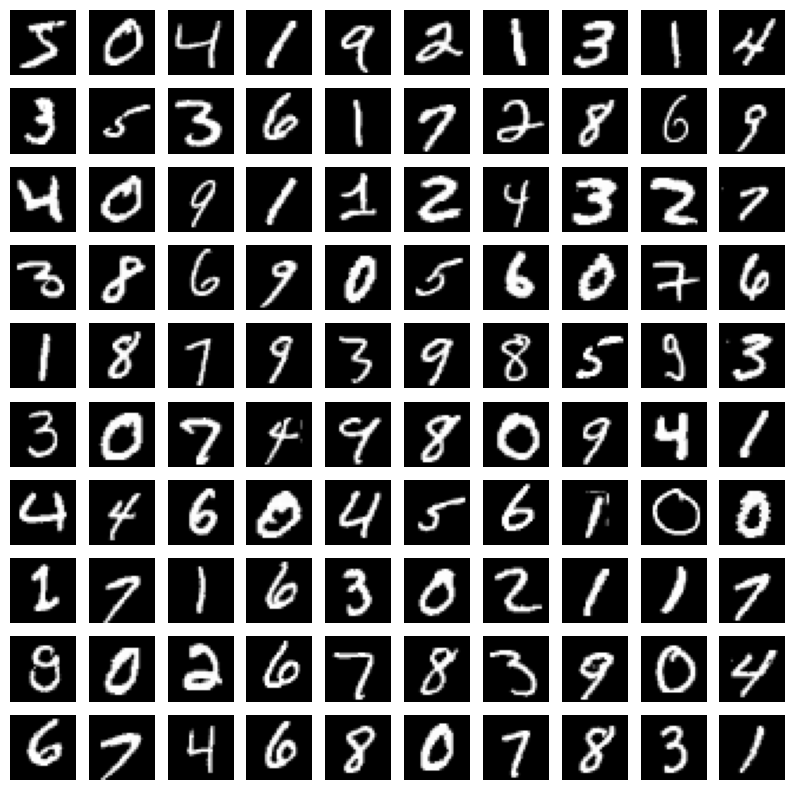

In [5]:
plot_sample_images(X_data, Y_data, n_samples = 100)

# 4. Dimensionality Reduction (Optional)

In [6]:
# Applying PCA to the data without specifying the number of components
pca_full = PCA()
pca_full.fit(X_data)

# Get the explained variance ratio (percentage of variance explained by each component)
explained_variance_ratio = pca_full.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find the number of components where the cumulative variance reaches 95%
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # Adding 1 for the correct indexex

# Apply PCA for commulative Variance reached 95%)
pca = PCA(n_components = n_components_95) 
X_data_pca = pca.fit_transform(X_data)
# Inverse transform to reconstruct images
X_reconstructed = pca.inverse_transform(X_data_pca)

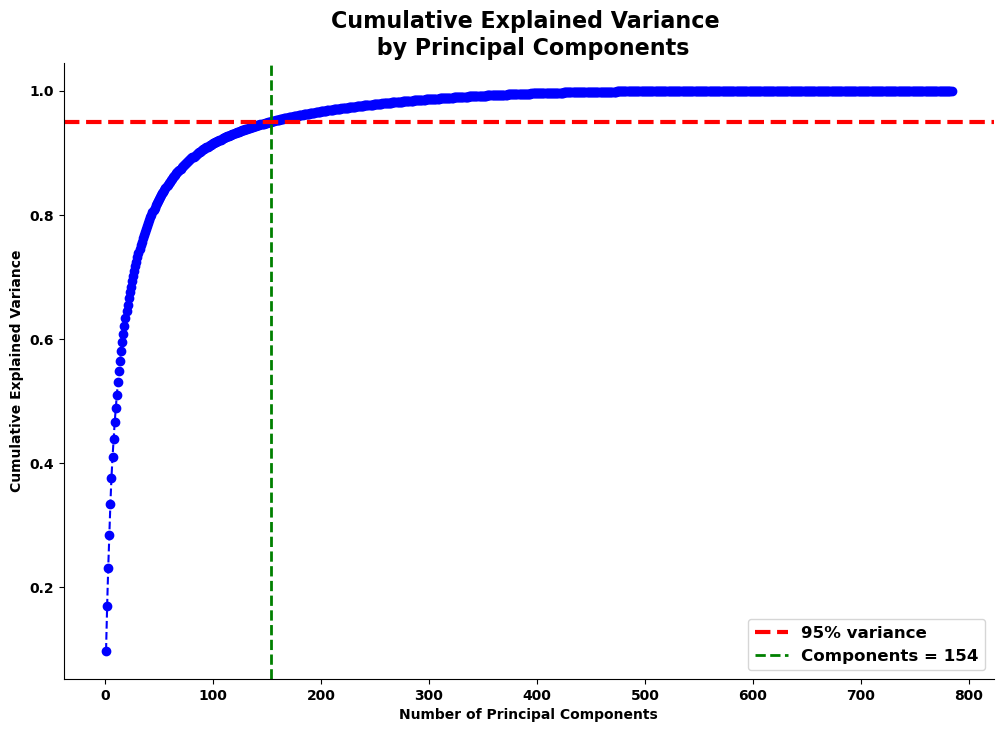

In [7]:

# Plot the explained variance and cumulative variance again
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1), 
         cumulative_variance, marker='o', 
         linestyle='--', color='b')
plt.title('Cumulative Explained Variance \n by Principal Components',
          fontsize = 16, fontweight = 'bold')
plt.xlabel('Number of Principal Components', fontweight = 'bold')
plt.ylabel('Cumulative Explained Variance', fontweight = 'bold')

# Plot the red horizontal line at 95% variance
plt.axhline(y=0.95, color='r', 
            linestyle='--', 
            label="95% variance", linewidth= 3)

# Plot the green vertical line at the point where variance reaches 0.95
plt.axvline(x=n_components_95, color='g', 
            linestyle='--', 
            label=f"Components = {n_components_95}", 
            linewidth = 2)
# Remove top and right borders (spines)
# Get the current axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(prop = {'weight': 'bold', 'size': 12})
plt.show()

In [8]:

# Display original and reconstructed images
def plot_compare_images(original, reconstructed, n=10, fig_size= (10,10)):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Reconstructed images
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title, fontsize = 16, fontweight = 'bold')
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, fontweight = 'bold')
    plt.yticks(tick_marks, tick_marks, fontweight = 'bold')
    
    # Label the counts inside the confusion matrix cells
    thresh = cm.max() / 2.  # threshold to set text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label', fontweight = 'bold')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.tight_layout()
    plt.show()

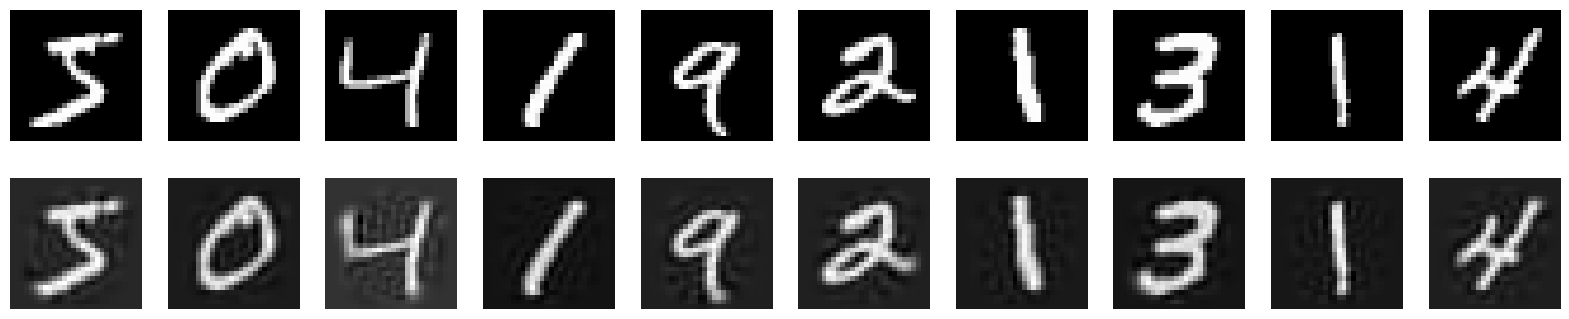

In [10]:
# Show the first 10 original and reconstructed images
plot_compare_images(X_data, X_reconstructed, n=10, fig_size = (20,18))

<center>
<b><span style="font-size: 36px;">Part 2: Machine Learning</span></b>
</center>

1.  Model Selection:<br>
     ➢ Choose several machine learning algorithms (e.g., SVM, Decision Trees, Random Forest, Gradient Boosting, k-NN, etc.).
     
     
2. Model Training:<br>
    ➢ Split the dataset into training and testing sets. (60,000 train and 10,000 test)
    
    ➢ Train each model on the training set.
    
3. Model Evaluation:

    ➢ Evaluate each model’s performance on the testing set using metrics such as accuracy, precision, recall, and F1-score.
    
    ➢ Use a confusion matrix to visualize the performance of each model.
    

In [11]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data_pca, Y_data, test_size=10000, random_state=42)

###  Train and use the model with the new observations
Save our newest trained model so we can so we can use it aagin later

In [12]:
# Initialize classifiers
models = {
    'Logistic regression': LR(max_iter = 1000),
    "Support Vector": SVC(),
    "Decision Tree": DTC(),
    "Random Forest": RFC(),
    "KNeighbours": KNN(),
    "Gradient Boosting": GBC(),}

# Train and evaluate each model
predictions = {}
compute_time = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Start time
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    # End time
    end_time = time.time()
    
    # Calculate runtime
    run_time = end_time - start_time
    
    compute_time.append((model_name, run_time))

    # Save the model as a pickle file
    filename = './models/'+model_name + 'digits_model_v02.pkl'
    joblib.dump(model, filename)
    del model

    # import loaded model
    model_loaded = joblib.load(filename)
    y_pred = model_loaded.predict(X_test)
    results = {model_name: y_pred}
    predictions.update(results)
predictions = pd.DataFrame(predictions)

Training Logistic regression...
Training Support Vector...
Training Decision Tree...
Training Random Forest...
Training KNeighbours...
Training Gradient Boosting...


In [13]:
# Assuming df is your DataFrame and you want to insert a new column 'new_column'
predictions.insert(0, 'y_true', y_test)

In [14]:
predictions.to_csv('results/model_prediction-results_v02.csv', index=False)

# 3. Model Evaluation:
 Evaluate each model’s performance on the testing set using metrics such as accuracy, precision, recall, and F1-score.

In [15]:
def weighted_accuracy(Y_true, Y_pred, model_name):
    # Calculate precision, recall, f1 score, and accuracy
    accuracy = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1 = f1_score(Y_true, Y_pred, average='weighted')

    weighte_performance = {'Accuracy': round(accuracy,3), 
                           'precision': round(precision, 3),
                           'recall': round(recall, 3), 
                           'f1_score': round(f1, 3)}
    df = pd.DataFrame([weighte_performance])
    df.rename(index = {0:model_name}, inplace = True)
    return df

In [16]:
weighted_accuracy_results = []
for i, name in enumerate(predictions.columns):
    if i > 0:
     #print(i, name)
     weighted_accuracy_results.append(weighted_accuracy(predictions.iloc[:,0], predictions.iloc[:,i], name))
weighted_accuracy_results = pd.concat(weighted_accuracy_results)

In [17]:
weighted_accuracy_results

,Accuracy,precision,recall,f1_score
Logistic regression,0.919,0.919,0.919,0.919
Support Vector,0.980,0.981,0.980,0.980
Decision Tree,0.829,0.828,0.829,0.828
Random Forest,0.946,0.946,0.946,0.946
KNeighbours,0.971,0.971,0.971,0.971
Gradient Boosting,0.923,0.923,0.923,0.923


In [18]:
weighted_accuracy_results.to_csv('results/model_weighted_performance_results_v02.csv', index=False)

In [19]:
def Compute_macro_Accuracy(Y_true, Y_pred, model_name):
    acc = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred, average='macro')
    recall = recall_score(Y_true, Y_pred, average='macro')
    F1_score = f1_score(Y_true, Y_pred, average='macro')
    performances = {'Accuracy': round(acc, 3), 
                    'precision': round(precision, 3),
                    'recall': round(recall,3), 
                    'f1_score': round(F1_score,3)}
    df_macro = pd.DataFrame([performances])
    df_macro.rename(index = {0:model_name}, inplace = True)
    return df_macro

In [21]:
macro_accuracy_results = []
for i, name in enumerate(predictions.columns):
    if i > 0:
     print(i, name)
     macro_accuracy_results.append(Compute_macro_Accuracy(predictions.iloc[:,0], predictions.iloc[:,i], name))

macro_accuracy_results = pd.concat(macro_accuracy_results)
macro_accuracy_results

1 Logistic regression
2 Support Vector
3 Decision Tree
4 Random Forest
5 KNeighbours
6 Gradient Boosting


,Accuracy,precision,recall,f1_score
Logistic regression,0.919,0.918,0.918,0.918
Support Vector,0.980,0.980,0.980,0.980
Decision Tree,0.829,0.826,0.826,0.826
Random Forest,0.946,0.946,0.946,0.946
KNeighbours,0.971,0.972,0.970,0.971
Gradient Boosting,0.923,0.922,0.922,0.922


In [22]:
# Concatenating the dataframes and setting the index to model names
# Performances = pd.concat([df_performance.rename(index={0: name}) for name, df_performance in accuracy_results])

macro_accuracy_results.to_csv('results/model_macro_performance_results_v02.csv', index=False)

In [23]:
for i, name in enumerate(predictions.columns):
    if i > 0:
     print(i, name, '\n')
     print(classification_report(predictions.iloc[:,0], predictions.iloc[:,i]))

1 Logistic regression 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       983
           1       0.95      0.97      0.96      1152
           2       0.90      0.90      0.90       967
           3       0.90      0.90      0.90      1034
           4       0.91      0.92      0.91       906
           5       0.88      0.87      0.88       937
           6       0.93      0.95      0.94       961
           7       0.93      0.94      0.93      1055
           8       0.90      0.87      0.88       969
           9       0.91      0.90      0.91      1036

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

2 Support Vector 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.99      0.99      0.99      1152
           2       0.97      0.99  

#### Use a confusion matrix to visualize the performance of each model.

1 Logistic regression 



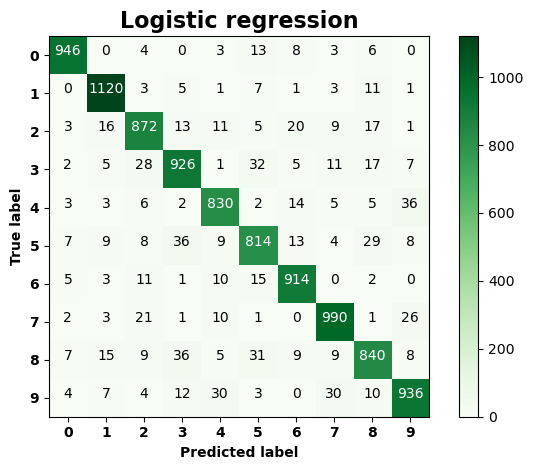

2 Support Vector 



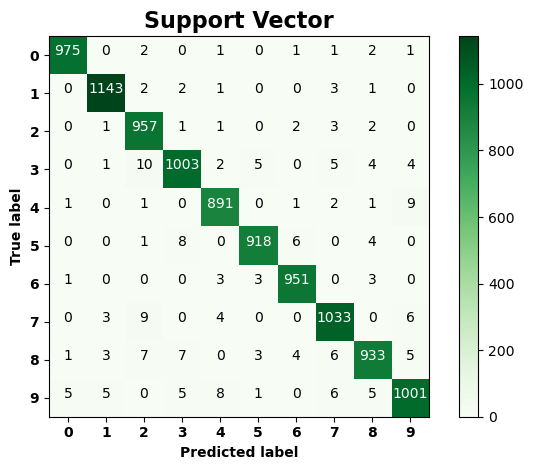

3 Decision Tree 



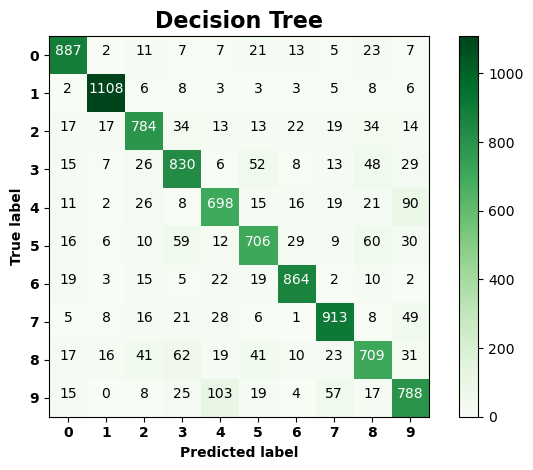

4 Random Forest 



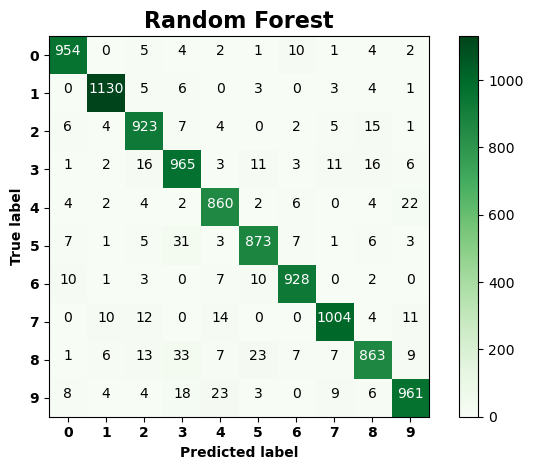

5 KNeighbours 



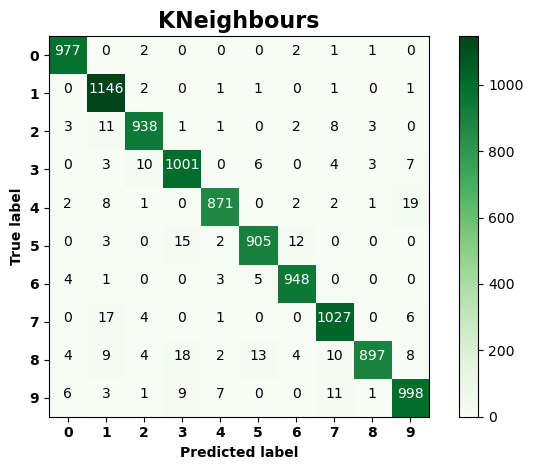

6 Gradient Boosting 



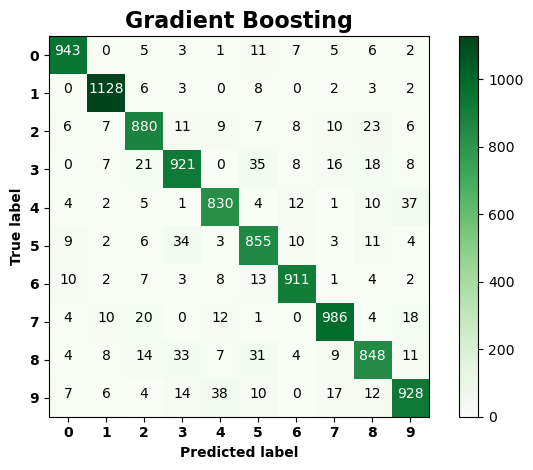

In [24]:
for i, name in enumerate(predictions.columns):
    if i > 0:
     print(i, name, '\n')
     cm = confusion_matrix(predictions.iloc[:,0], predictions.iloc[:,i])
     plot_confusion_matrix(cm, title=name)

<center>
<b><span style="font-size: 36px;">Part 3: Hyperparameter Tuning</span></b>
    
1. Grid Search:
    
     ➢ Perform grid search cross-validation to find the optimal hyperparameters for each model.

# Define hyperparameter for each model

In [25]:

# Define parameter grids for each model
param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 5, 10], 'solver': ['newton-cg', 'sag', 'saga','lbfgs']}

param_grid_svc = {'C': [0.01, 0.1, 1.0, 5, 10], 'kernel': ['linear', 'rbf'],}

# Define the parameter grid for the DecisionTreeClassifier
param_grid_dt = {'max_depth': [None, 3, 7, 11], 'min_samples_split': [2, 5,  9],}

param_grid_rfc = {'n_estimators': [50, 70, 100, 120, 150], 'max_depth': [None, 5, 10, 15],} 

# Define the prmeters fot KNN
param_grid_knn = {'n_neighbors': [1, 3, 5, 7,9], 'p': [1, 2, 5, 9] } 
# Define the parameter grid for GradientBoostingClassifier
param_grid_gb = {'n_estimators': [50, 70, 100, 120, 150], 'learning_rate': [0.001, 0.01, 0.1,  0.5],}

Parameters = [param_grid_lr, param_grid_svc, param_grid_dt, param_grid_rfc, param_grid_knn, param_grid_gb] 

In [26]:
# best_estimators = {}
# predictions_best = {}
# for (model_name, model), param_grid in zip(models.items(), Parameters):
#     if model_name == "KNeighbours" or model_name == "Gradient Boosting":
#         print('Skip for KNeighbours or Gradient Boosting')
#     else:
#         print(f"Running GridSearchCV for {model_name}...")
#         grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
#         grid_search.fit(X_train, y_train)
#         best_model = grid_search.best_estimator_
#         # Save the model as a pickle file
#         filename_best = './models/'+model_name + '_best_digits_model.pkl'
#         joblib.dump(best_model, filename_best)
#         del best_model
#         # import loaded model
#         model_loaded_best = joblib.load(filename_best)

#         y_pred = model_loaded_best.predict(X_test)
#         results_cv = {model_name: y_pred}
#         predictions_best.update(results_cv)
#         print(f"Best parameters for {model_name}: {grid_search.best_params_}")
#         print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}\n")
#         #print(model_name, model, param_grid)
    
# predictions_best = pd.DataFrame(predictions_best)

In [27]:
best_estimators = {}
predictions_best = {}
best_run_time = []
for (model_name, model), param_grid in zip(models.items(), Parameters):
    #if model_name == "KNeighbours" or model_name == "Gradient Boosting":
    #    print('Skip for KNeighbours or Gradient Boosting')
    #else:
    print(f"Running GridSearchCV for {model_name}...")
    start_time = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    
    run_time = end_time - start_time
    
    best_run_time.append((model_name, run_time))
    
    best_model = grid_search.best_estimator_
    # Save the model as a pickle file
    filename_best = './models/'+model_name + '_best_digits_model_v02.pkl'
    joblib.dump(best_model, filename_best)
    del best_model
    # import loaded model
    model_loaded_best = joblib.load(filename_best)

    y_pred = model_loaded_best.predict(X_test)
    results_cv = {model_name: y_pred}
    predictions_best.update(results_cv)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}\n")
    #print(model_name, model, param_grid)
    
predictions_best = pd.DataFrame(predictions_best)

Running GridSearchCV for Logistic regression...
Best parameters for Logistic regression: {'C': 5, 'solver': 'lbfgs'}
Best cross-validation score for Logistic regression: 0.9208000000000001

Running GridSearchCV for Support Vector...
Best parameters for Support Vector: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score for Support Vector: 0.9847333333333333

Running GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 9}
Best cross-validation score for Decision Tree: 0.8259333333333334

Running GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 150}
Best cross-validation score for Random Forest: 0.9482166666666668

Running GridSearchCV for KNeighbours...
Best parameters for KNeighbours: {'n_neighbors': 3, 'p': 5}
Best cross-validation score for KNeighbours: 0.9735333333333334

Running GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_ra

In [28]:
predictions_best

,Logistic regression,Support Vector,Decision Tree,Random Forest,KNeighbours,Gradient Boosting
0,8,8,8,8,8,8
1,4,4,9,4,4,4
2,5,8,8,8,8,5
3,7,7,7,7,7,7
4,7,7,7,7,7,7
...,...,...,...,...,...,...
9995,2,2,2,2,2,2
9996,8,8,8,8,8,8
9997,3,3,5,3,3,3
9998,3,8,3,8,3,8


In [29]:
# Assuming df is your DataFrame and you want to insert a new column 'new_column'
predictions_best.insert(0, 'y_true', y_test)
predictions_best.to_csv('results/best_model_prediction_results_v02.csv', index=False)

In [30]:
predictions_best

,y_true,Logistic regression,Support Vector,Decision Tree,Random Forest,KNeighbours,Gradient Boosting
0,8,8,8,8,8,8,8
1,4,4,4,9,4,4,4
2,8,5,8,8,8,8,5
3,7,7,7,7,7,7,7
4,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...
9995,2,2,2,2,2,2,2
9996,8,8,8,8,8,8,8
9997,3,3,3,5,3,3,3
9998,8,3,8,3,8,3,8


<center>
<b><span style="font-size: 36px;">Part 4: Reporting</span></b>
</center>

1.  Results Compilation:

     ➢ Compile the results from each model into a report.
     
     ➢ Include visualizations such as ROC curves and Precision-Recall curves.
     
2. Discussion:

     ➢ Discuss the performance of each model and the impact of preprocessing techniques.
     
     ➢ Provide insights on which model worked best and hypothesize why.
     

In [31]:
best_weighted_accuracy_results = []
for i, name in enumerate(predictions_best.columns):
    if i > 0:
     #print(i, name)
     best_weighted_accuracy_results.append(weighted_accuracy(predictions_best.iloc[:,0], predictions_best.iloc[:,i], name))
best_weighted_accuracy_results = pd.concat(best_weighted_accuracy_results)
best_weighted_accuracy_results

,Accuracy,precision,recall,f1_score
Logistic regression,0.919,0.919,0.919,0.919
Support Vector,0.983,0.983,0.983,0.983
Decision Tree,0.832,0.831,0.832,0.831
Random Forest,0.950,0.950,0.950,0.950
KNeighbours,0.973,0.973,0.973,0.973
Gradient Boosting,0.933,0.933,0.933,0.933


In [32]:
best_weighted_accuracy_results.to_csv('results/best_model_weighted_performance_results_v02.csv', index=False)

In [33]:
best_macro_accuracy_results = []
for i, name in enumerate(predictions_best.columns):
    if i > 0:
     print(i, name)
     best_macro_accuracy_results.append(Compute_macro_Accuracy(predictions_best.iloc[:,0], predictions_best.iloc[:,i], name))

best_macro_accuracy_results = pd.concat(best_macro_accuracy_results)
best_macro_accuracy_results

1 Logistic regression
2 Support Vector
3 Decision Tree
4 Random Forest
5 KNeighbours
6 Gradient Boosting


,Accuracy,precision,recall,f1_score
Logistic regression,0.919,0.918,0.918,0.918
Support Vector,0.983,0.983,0.983,0.983
Decision Tree,0.832,0.828,0.829,0.829
Random Forest,0.950,0.950,0.950,0.950
KNeighbours,0.973,0.973,0.973,0.973
Gradient Boosting,0.933,0.932,0.932,0.932


In [34]:
macro_accuracy_results.to_csv('results/best_model_macro_performance_results_v02.csv', index=False)

In [35]:
for i, name in enumerate(predictions_best.columns):
    if i > 0:
     print(i, name, '\n')
     print(classification_report(predictions_best.iloc[:,0], predictions_best.iloc[:,i]))

1 Logistic regression 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       983
           1       0.95      0.97      0.96      1152
           2       0.90      0.90      0.90       967
           3       0.90      0.90      0.90      1034
           4       0.91      0.92      0.91       906
           5       0.88      0.87      0.87       937
           6       0.93      0.95      0.94       961
           7       0.93      0.94      0.93      1055
           8       0.90      0.87      0.88       969
           9       0.91      0.90      0.91      1036

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

2 Support Vector 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       1.00      0.99      0.99      1152
           2       0.97      0.99  

1 Logistic regression 



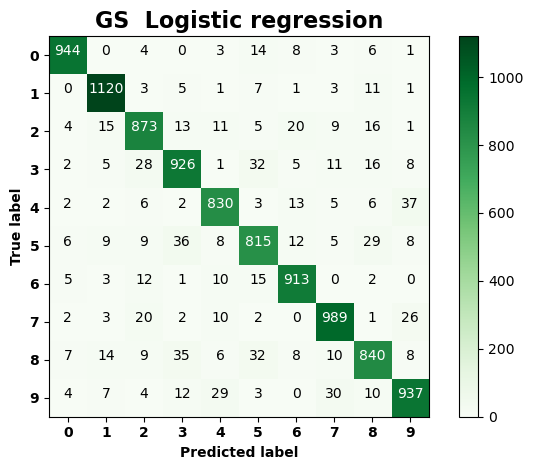

2 Support Vector 



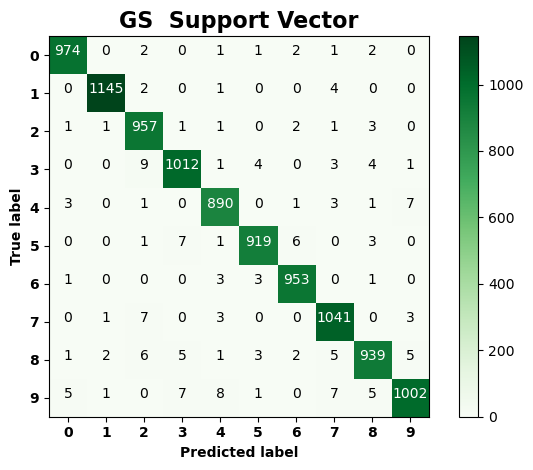

3 Decision Tree 



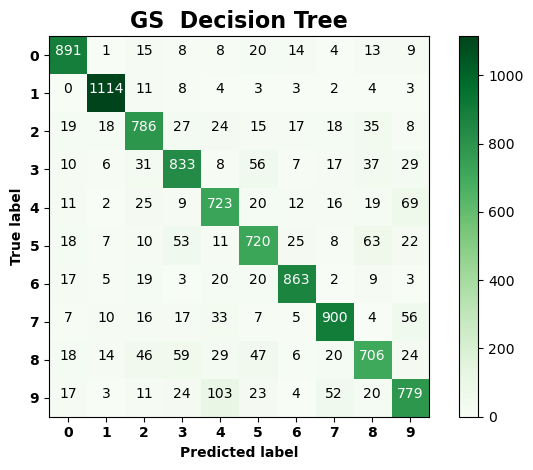

4 Random Forest 



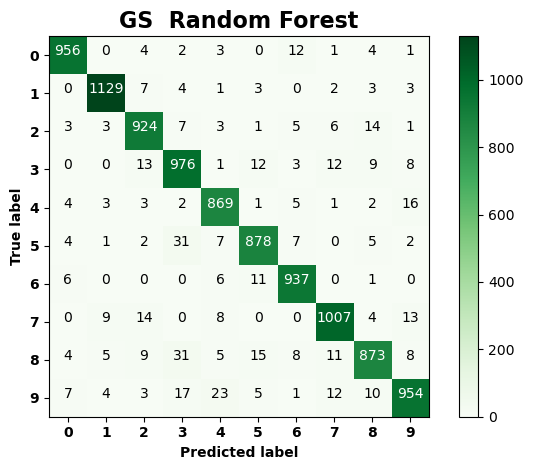

5 KNeighbours 



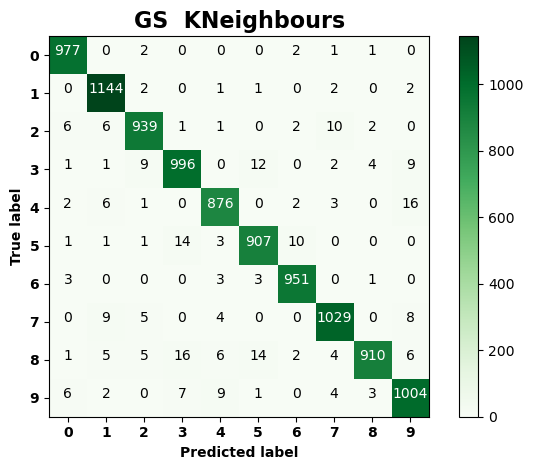

6 Gradient Boosting 



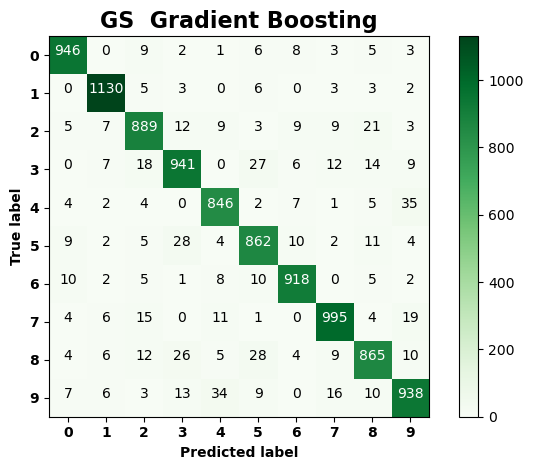

In [36]:
for i, name in enumerate(predictions_best.columns):
    if i > 0:
     print(i, name, '\n')
     cm = confusion_matrix(predictions_best.iloc[:,0], predictions_best.iloc[:,i])
     plot_confusion_matrix(cm, title='GS  '+  name )

In [37]:
def ROC_curves(Y_test, Y_pred, model_name = None):
    # Binarize the output labels (convert them to one-vs-rest format)
    y_true = label_binarize(Y_test, classes=np.unique(Y_test))
    Y_pred = label_binarize(Y_pred, classes=np.unique(Y_pred))
    n_classes = y_true.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area (aggregate of all classes)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), Y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class and the micro-average ROC curve
    plt.figure(figsize = (10,8))
    plt.plot(fpr["micro"], tpr["micro"], 
             label='Micro-Average (A = {0:0.2f})'.format(roc_auc["micro"]))

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='Class {0} (A = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight = 'bold')
    plt.ylabel('True Positive Rate', fontweight = 'bold')
    plt.xticks(fontweight = 'bold')
    plt.yticks(fontweight = 'bold')
    plt.title(model_name + ' ROCs \n  Handwritten Digit Classification', fontweight = 'bold', fontsize = 16)
    plt.legend(loc="lower right", ncol = 2)
    plt.show()

In [38]:
def Precision_Recall_curves(Y_test, Y_pred, model_name = None):
    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    # Binarize the output labels (convert them to one-vs-rest format for multi-class precision-recall)
    y_true = label_binarize(Y_test, classes=np.unique(Y_test))
    Y_pred = label_binarize(Y_pred, classes=np.unique(Y_pred))
    n_classes = y_true.shape[1]

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], Y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], Y_pred[:, i])

    # Compute micro-average Precision-Recall curve and average precision score
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), Y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_true, Y_pred, average="micro")

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
    plt.plot(recall["micro"], precision["micro"], label='Micro-average P-R curve (A = {0:0.2f})'
                                                       ''.format(average_precision["micro"]))

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], color=colors[i], lw=2,
                 label='Class {0} (A = {1:0.2f})'.format(i, average_precision[i]))

    plt.xlabel('Recall', fontweight = 'bold')
    plt.ylabel('Precision', fontweight = 'bold')
    plt.xticks(fontweight = 'bold')
    plt.yticks(fontweight = 'bold')
    plt.title(model_name + ' P-R curves \n Handwritten Digit Classification', fontweight = 'bold', fontsize = 16)
    plt.legend(loc="lower left", ncol = 2)
    plt.show()

    # Print classification report for additional insights
    print(classification_report(Y_test, y_pred))

1 Logistic regression 



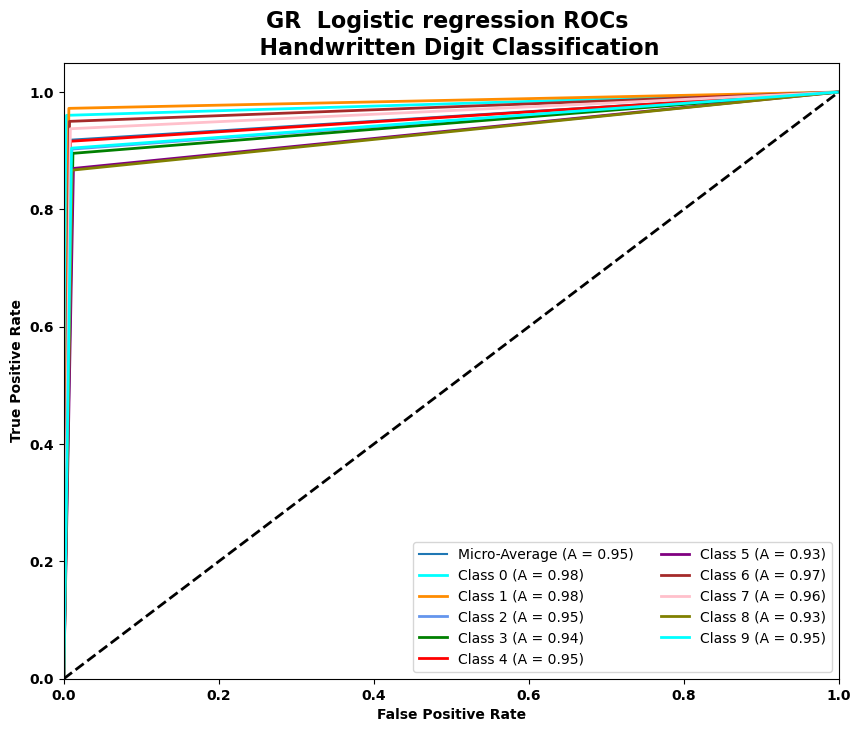

2 Support Vector 



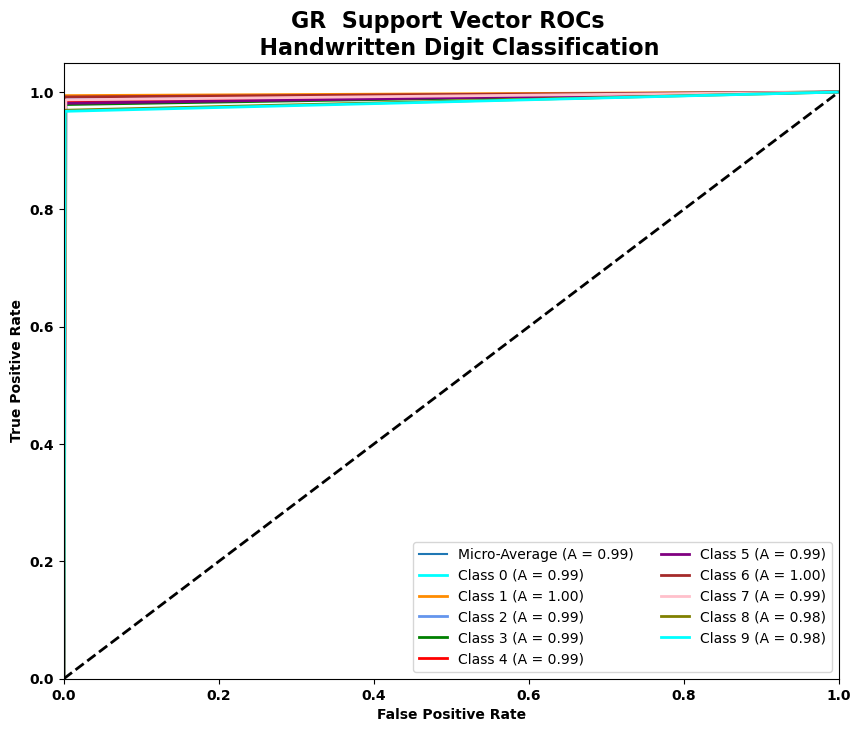

3 Decision Tree 



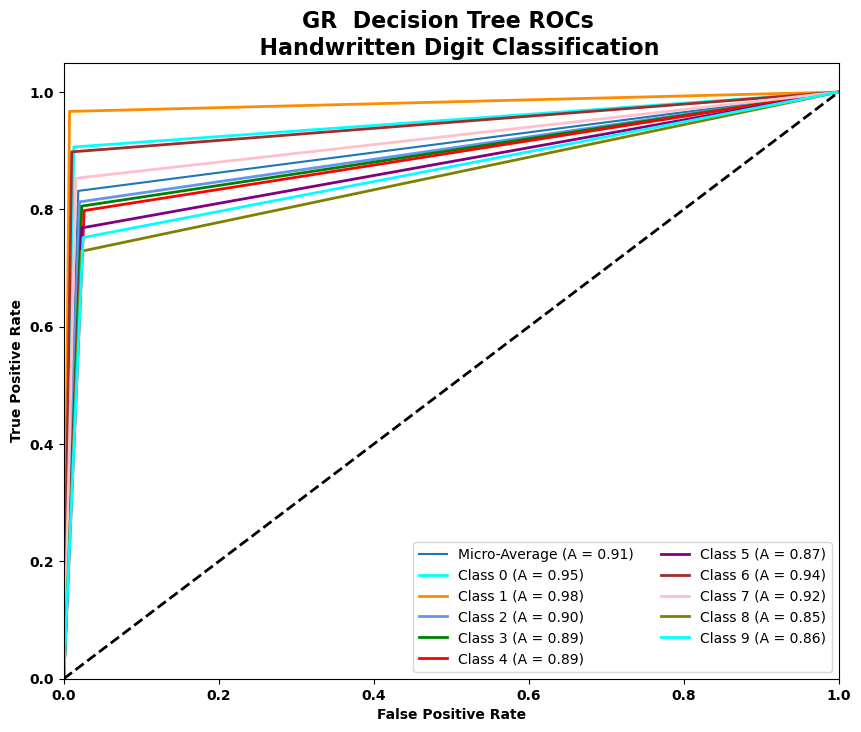

4 Random Forest 



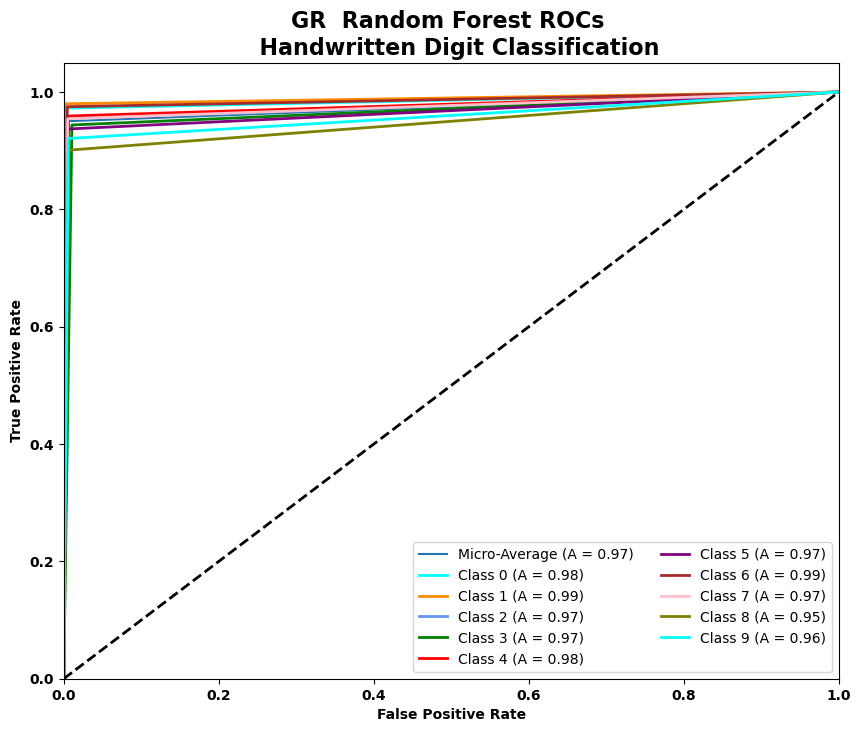

5 KNeighbours 



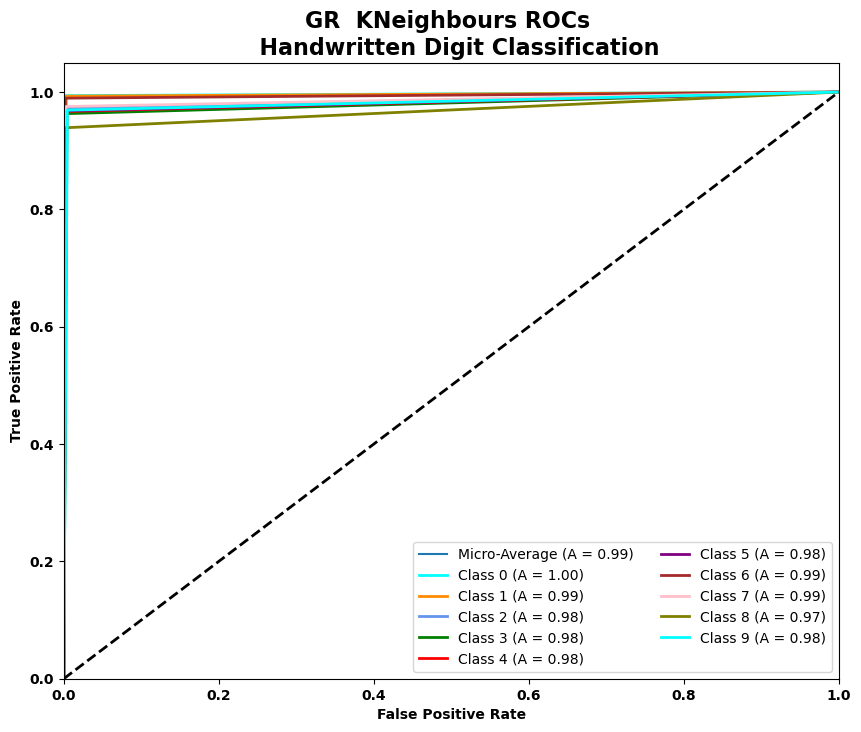

6 Gradient Boosting 



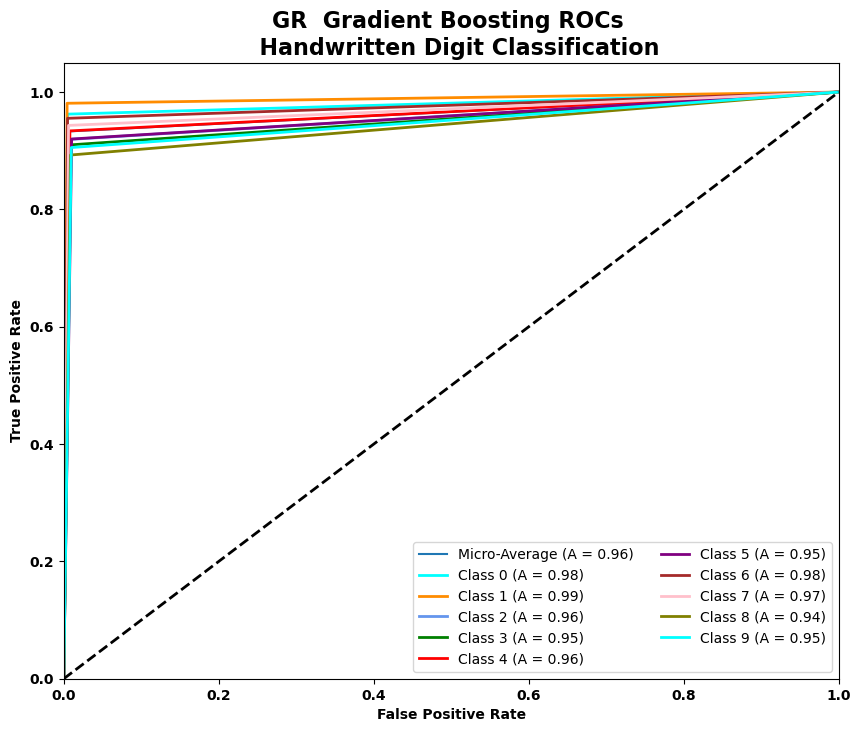

In [39]:
for i, name in enumerate(predictions_best.columns):
    if i > 0:
     print(i, name, '\n')
     ROC_curves(predictions_best.iloc[:,0], predictions_best.iloc[:,i], model_name ='GR  '+ name)

1 Logistic regression 



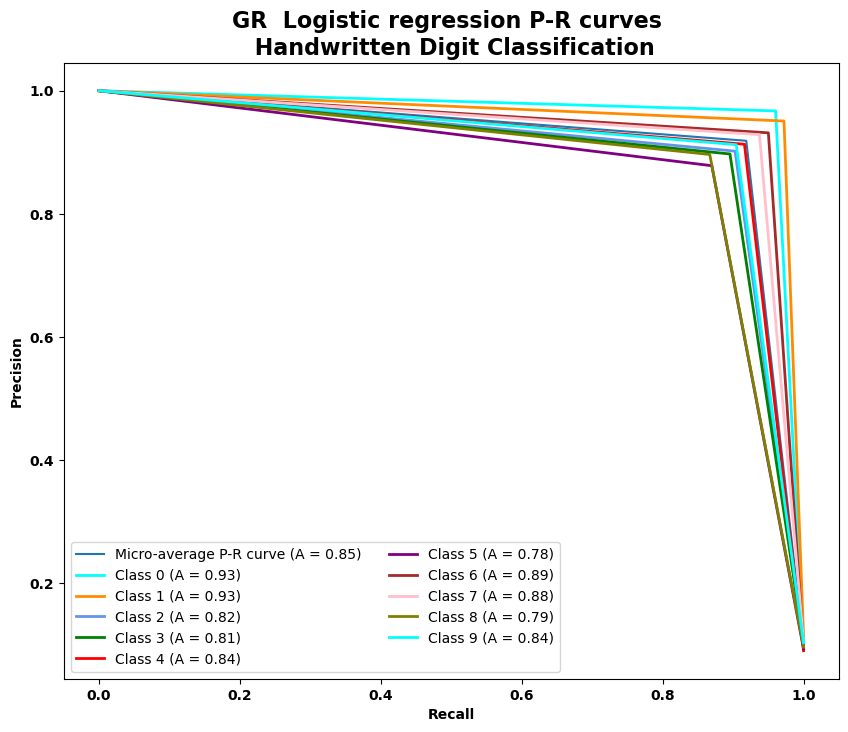

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.97      0.98      0.97      1152
           2       0.92      0.92      0.92       967
           3       0.92      0.91      0.91      1034
           4       0.92      0.93      0.93       906
           5       0.90      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.94      0.95      1055
           8       0.92      0.89      0.90       969
           9       0.92      0.91      0.91      1036

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

2 Support Vector 



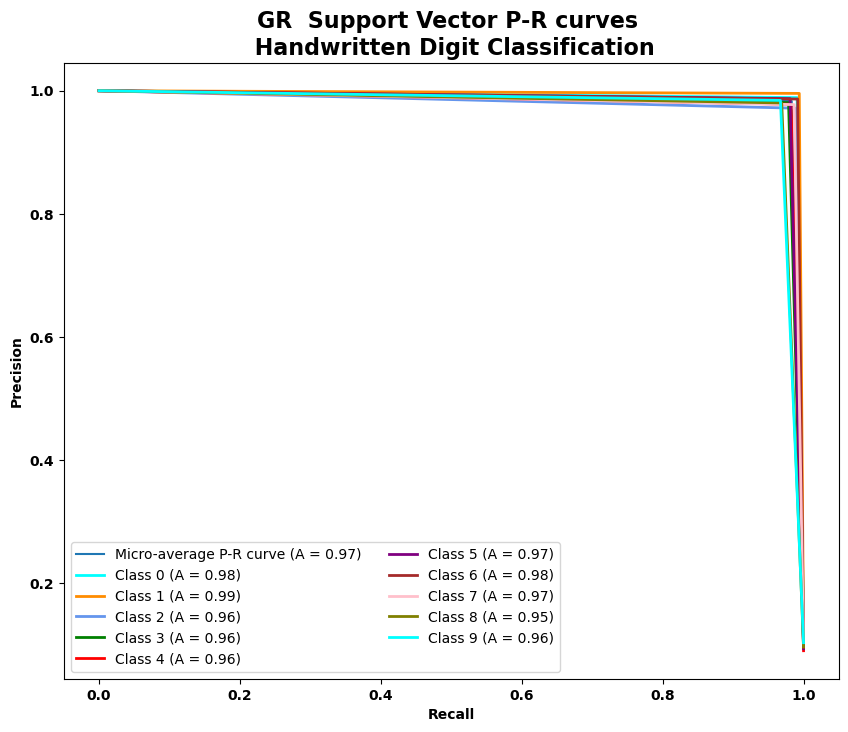

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.97      0.98      0.97      1152
           2       0.92      0.92      0.92       967
           3       0.92      0.91      0.91      1034
           4       0.92      0.93      0.93       906
           5       0.90      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.94      0.95      1055
           8       0.92      0.89      0.90       969
           9       0.92      0.91      0.91      1036

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

3 Decision Tree 



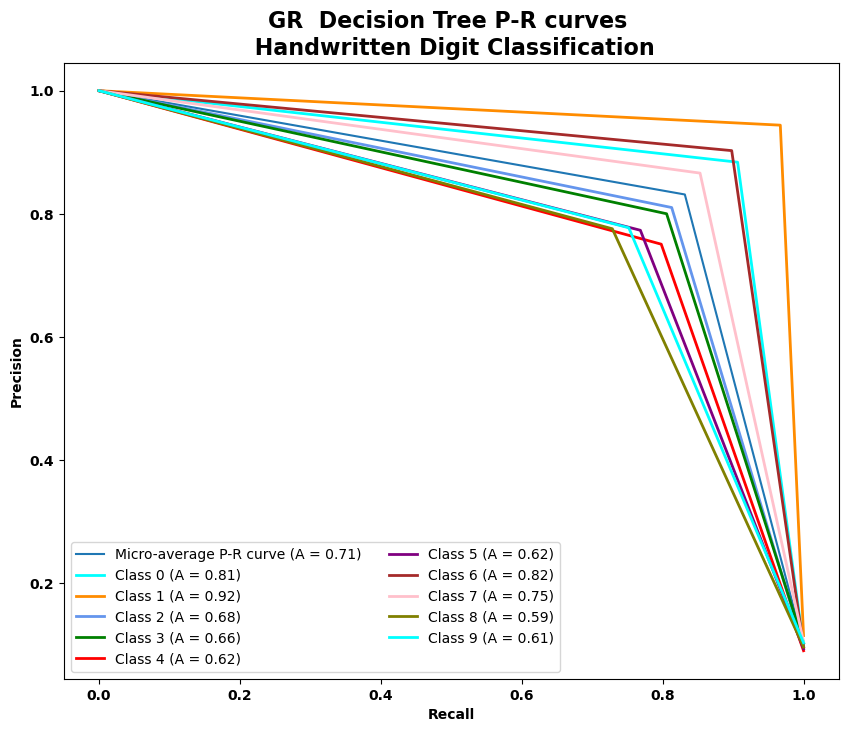

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.97      0.98      0.97      1152
           2       0.92      0.92      0.92       967
           3       0.92      0.91      0.91      1034
           4       0.92      0.93      0.93       906
           5       0.90      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.94      0.95      1055
           8       0.92      0.89      0.90       969
           9       0.92      0.91      0.91      1036

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

4 Random Forest 



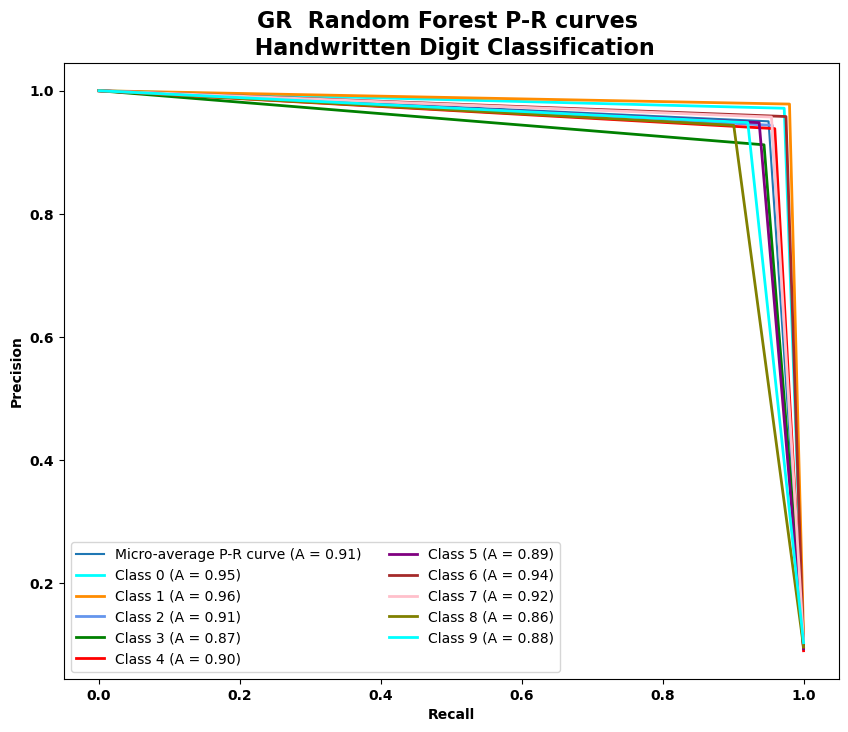

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.97      0.98      0.97      1152
           2       0.92      0.92      0.92       967
           3       0.92      0.91      0.91      1034
           4       0.92      0.93      0.93       906
           5       0.90      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.94      0.95      1055
           8       0.92      0.89      0.90       969
           9       0.92      0.91      0.91      1036

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

5 KNeighbours 



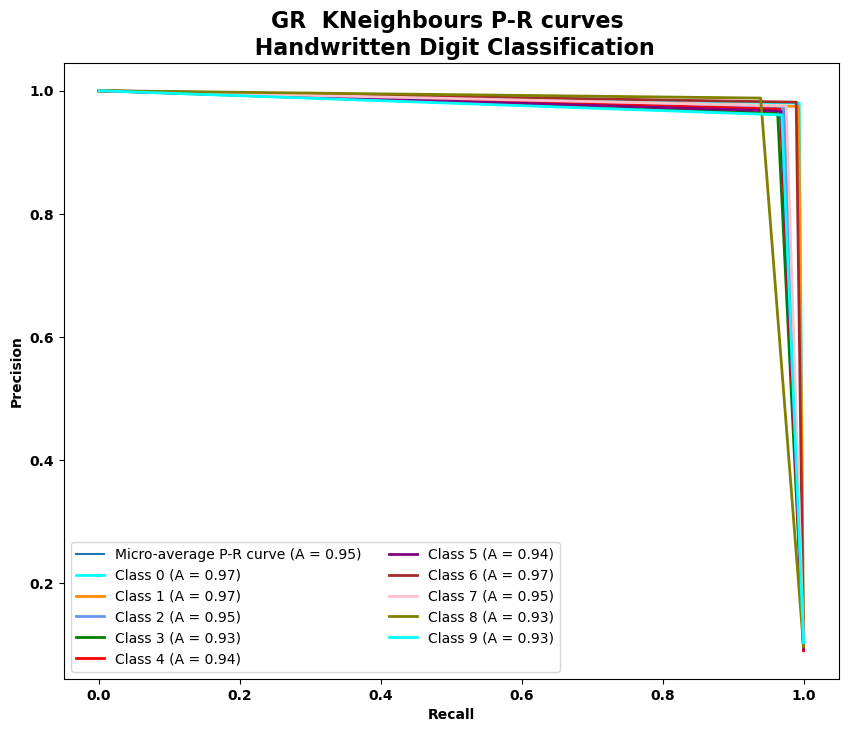

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.97      0.98      0.97      1152
           2       0.92      0.92      0.92       967
           3       0.92      0.91      0.91      1034
           4       0.92      0.93      0.93       906
           5       0.90      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.94      0.95      1055
           8       0.92      0.89      0.90       969
           9       0.92      0.91      0.91      1036

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

6 Gradient Boosting 



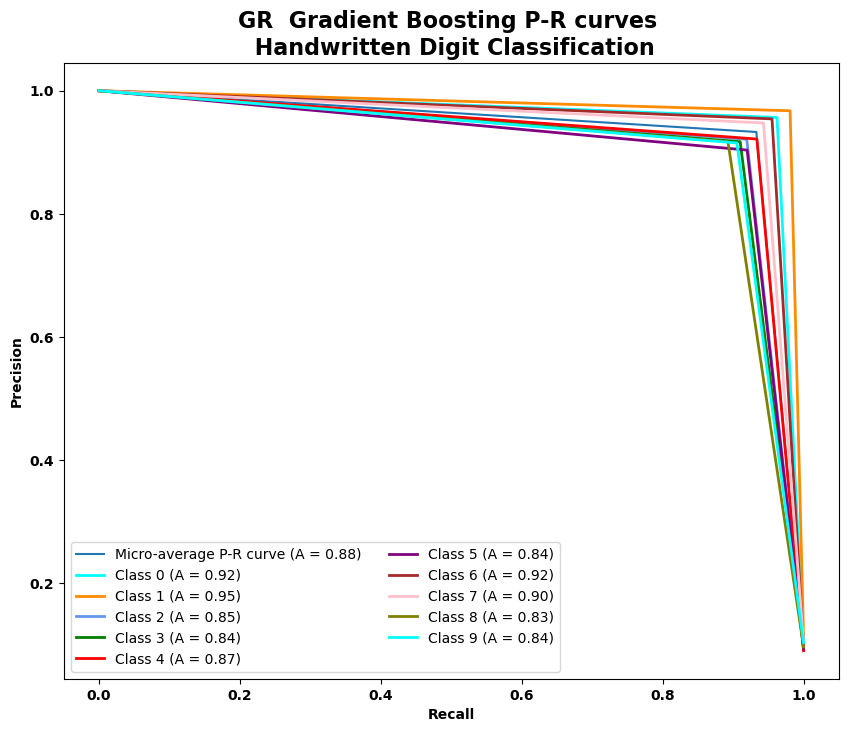

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.97      0.98      0.97      1152
           2       0.92      0.92      0.92       967
           3       0.92      0.91      0.91      1034
           4       0.92      0.93      0.93       906
           5       0.90      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.94      0.95      1055
           8       0.92      0.89      0.90       969
           9       0.92      0.91      0.91      1036

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [40]:
for i, name in enumerate(predictions_best.columns):
    if i > 0:
     print(i, name, '\n')
     Precision_Recall_curves(predictions_best.iloc[:,0], predictions_best.iloc[:,i], model_name ='GR  '+ name)

<center>
<b><span style="font-size: 36px;">Run time comparision</span></b>
</center>

In [57]:
normal_run = pd.DataFrame({compute_time[i][0] : [compute_time[i][1]] for i in range(len(compute_time))})
normal_run.rename(index = {0:'without gs runtime (sec)'}, inplace = True)
normal_run

,Logistic regression,Support Vector,Decision Tree,Random Forest,KNeighbours,Gradient Boosting
without gs runtime (sec),4.915085,19.032469,19.589298,59.824199,0.004061,2133.303819


In [58]:
gs_normal_run = pd.DataFrame({best_run_time[i][0] : [best_run_time[i][1]] for i in range(len(best_run_time))})
gs_normal_run.rename(index = {0: 'With gs runtime (sec)'}, inplace = True)
gs_normal_run

,Logistic regression,Support Vector,Decision Tree,Random Forest,KNeighbours,Gradient Boosting
With gs runtime (sec),290.963642,869.366965,54.793872,367.267704,5838.642686,17641.048542


In [59]:
running_time = pd.concat([normal_run, gs_normal_run])
running_time

,Logistic regression,Support Vector,Decision Tree,Random Forest,KNeighbours,Gradient Boosting
without gs runtime (sec),4.915085,19.032469,19.589298,59.824199,0.004061,2133.303819
With gs runtime (sec),290.963642,869.366965,54.793872,367.267704,5838.642686,17641.048542


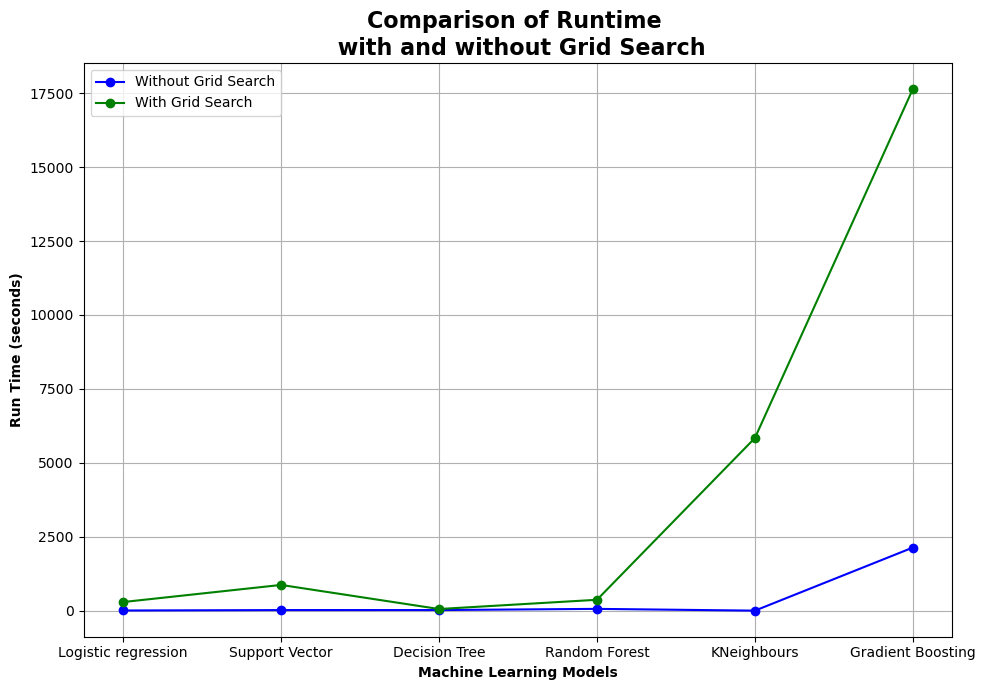

In [64]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['Logistic regression', 'Support Vector', 'Decision Tree', 'Random Forest', 'KNeighbours', 'Gradient Boosting']
without_gs_runtime = [4.915085, 19.032469, 19.589298, 59.824199, 0.004061, 2133.303819]
with_gs_runtime = [290.963642, 869.366965, 54.793872, 367.267704, 5838.642686, 17641.048542]

# Plotting the line graph for comparison including percentage differences
plt.subplots(figsize=(10, 7))

# Line plot for both datasets
plt.plot(models, without_gs_runtime, marker='o', label='Without Grid Search', color='blue')
plt.plot(models, with_gs_runtime, marker='o', label='With Grid Search', color='green')

# Set labels and title for the first y-axis (run times)
plt.xlabel('Machine Learning Models', fontweight = 'bold')
plt.ylabel('Run Time (seconds)', fontweight = 'bold')
plt.title('Comparison of Runtime \n with and without Grid Search', fontweight = 'bold', fontsize = 16)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()